## Vehicle Detection (Using HOG)

In this project we are going to detect cars from the video stream.

### Imports

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from queue import *
import os
from PIL import Image as IMG
from IPython.display import Image
from IPython.display import display
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
from moviepy.editor import *
from IPython.display import HTML
import warnings
from moreFunctions import *
from skimage.feature import hog
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from scipy.misc import imread
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

## Filepaths for images

No. of images containing vehicles :  8792
No. of images not containing vehicles :  8968
Total No. images:  17760


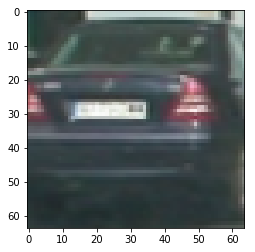

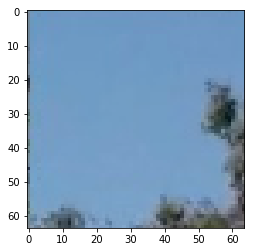

In [16]:
# File paths for all images containing Vehicles
vehicle_images = glob.glob('./vehicles/vehicles/**/*.png', recursive=True)
print("No. of images containing vehicles : " ,np.array(vehicle_images).shape[0])
# File paths for all images not containing a Vehicle
non_vehicle_images = glob.glob('./non-vehicles/non-vehicles/**/*.png', recursive=True)
print("No. of images not containing vehicles : " ,np.array(non_vehicle_images).shape[0])

# Concatenating the file paths
concat_images = np.concatenate((vehicle_images, non_vehicle_images))
print("Total No. images: ",concat_images.shape[0])

fig = plt.figure()
image = imread(vehicle_images[1000], mode='RGB')
plt.imshow(image)
fig.savefig('./output_images/car.jpg', bbox_inches='tight')
# Only one variable is enough as the image is 64x64x3
img_shape = image.shape[0]

fig = plt.figure()
image = imread(non_vehicle_images[0], mode='RGB')
plt.imshow(image)
fig.savefig('./output_images/not_car.jpg', bbox_inches='tight')

## Pipeline for detecting vehicles

### Setting the paramaters

In [3]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hist_bins = 16
spatial_size = (16,16)

## CLAHE Transform

In [4]:
def clahe_transform(X_batch):
    output_c = np.empty(X_batch.shape)

    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    
    image = X_batch
    image = image.astype(np.uint8)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    transform = clahe.apply(l)
    temp = cv2.merge((transform,a,b))
    output_c = cv2.cvtColor(temp, cv2.COLOR_LAB2RGB)

    return output_c

### Genetrating the feature Vector

In [5]:

vehicle_feature = []
non_vehicle_feature = []

for i,img_path in enumerate(vehicle_images):
    img = imread(img_path, mode='RGB')
    #img = clahe_transform(img)
    temp_feature,_ = feature_extraction(img, cspace=colorspace, re_img=spatial_size, 
                                             hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                             cell_per_block=cell_per_block)
    vehicle_feature.append(temp_feature)
    
    
for i,img_path in enumerate(non_vehicle_images):
    img = imread(img_path, mode='RGB')
    #img = clahe_transform(img)
    temp_feature,_ = feature_extraction(img, cspace=colorspace, re_img=spatial_size, 
                                             hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                             cell_per_block=cell_per_block)
    non_vehicle_feature.append(temp_feature)


D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
print(len(vehicle_feature))
print(len(non_vehicle_feature))
concat_X = np.concatenate((vehicle_feature, non_vehicle_feature))
print("Total size of the feature vector: ", concat_X.shape)
concat_X = concat_X.astype(np.float64)

X_scaler = StandardScaler().fit(concat_X)
scaled_X = X_scaler.transform(concat_X)

#scaled_X = concat_X

vehicle_ones = np.ones(len(vehicle_feature))
non_vehicles_zeros = np.zeros(len(non_vehicle_feature))

Y = np.hstack((vehicle_ones, non_vehicles_zeros))
print("Total size of the Y vector: ", Y.shape)

8792
8968
Total size of the feature vector:  (17760, 11400)
Total size of the Y vector:  (17760,)


Max:  186
Min:  31


D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


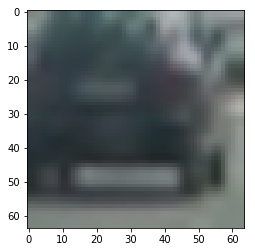

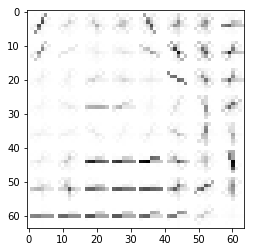

In [23]:
temp_img = imread(concat_images[31], mode='RGB')
#temp_img = clahe_transform(temp_img)
fig = plt.figure()
plt.imshow(temp_img)
fig.savefig('./output_images/Original.jpg', bbox_inches='tight')
print("Max: ", np.amax(temp_img))
print("Min: ", np.amin(temp_img))
temp_img = color_space(temp_img, colorspace)
some_features, temp_img = feature_extraction(temp_img, cspace=colorspace, re_img=spatial_size, 
                                             hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,
                                             cell_per_block=cell_per_block)
fig = plt.figure()
plt.imshow(temp_img[:,:,1], cmap='Greys')
fig.savefig('./output_images/HOG.jpg', bbox_inches='tight')

### Training the Classifier

In [8]:
"""
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(scaled_X, Y)
print(clf.best_params_)
"""
X_shuffel,Y_shuffel = shuffle(scaled_X, Y)

#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_shuffel, Y_shuffel, test_size=0.2)

clf = LinearSVC()
clf.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9814


In [9]:
some_features = X_shuffel[0]

some_features = some_features.reshape(1, -1) 

print("Predicted: ", clf.predict(some_features))

print(Y_shuffel[0])

Predicted:  [ 0.]
0.0


### Searching for vehicles an image

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, draw_img, ystart, ystop, scale, colorspace, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_space(img_tosearch, colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0] # For shape

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Change the colorspace of the image
    ctrans_tosearch = color_space(ctrans_tosearch, colorspace)
    
    # Applying CLAHE Transform
    #ctrans_tosearch = clahe_transform(ctrans_tosearch)
    
    # Compute individual channel HOG features for the entire image
    hog1, hog2, hog3, _ = hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #print(hog1.shape)
    
    # Declaring an array for storing the bounding boxes
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_final = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, spatial_size)
            hist_features = histogram_formation(subimg, hist_bins)
            
            #print("two ",spatial_features.shape)
            #print("three ",hist_features.shape)
            #print("four ",hog_final.shape)
            
            # Scale features and make a prediction
            temp_test = np.concatenate((spatial_features, hist_features, hog_final))
            #print("five ",temp_test.shape)
            temp_test = temp_test.reshape(1, -1) 
            test_features = scaler.transform(temp_test)    
            #test_features = temp_test
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),3) 
                upper_left, bottom_right = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((upper_left, bottom_right))
    
    return draw_img, boxes

## Defining heatmaps for removing False Positives

In [11]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


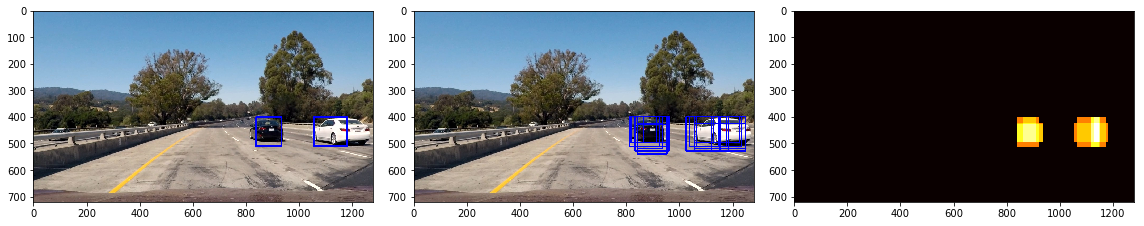

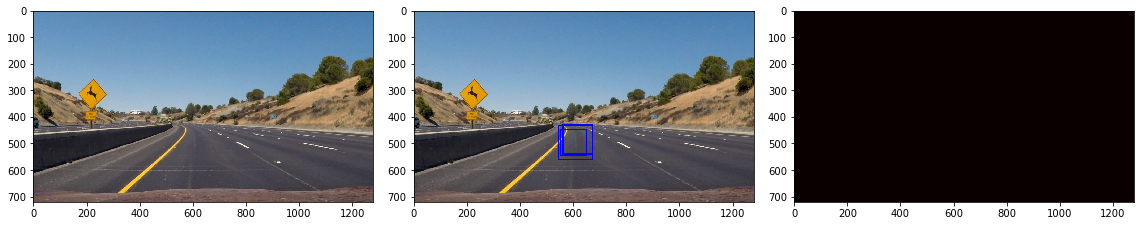

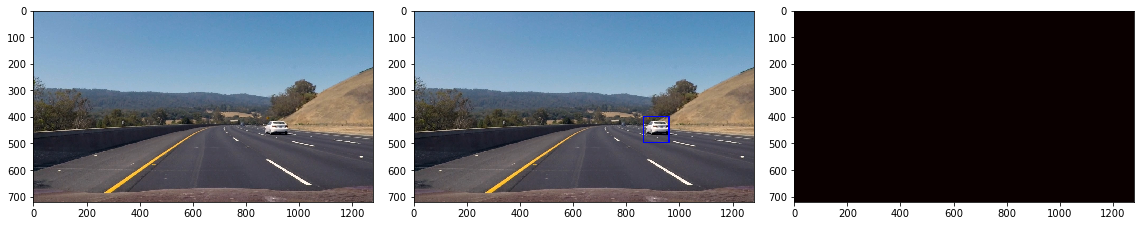

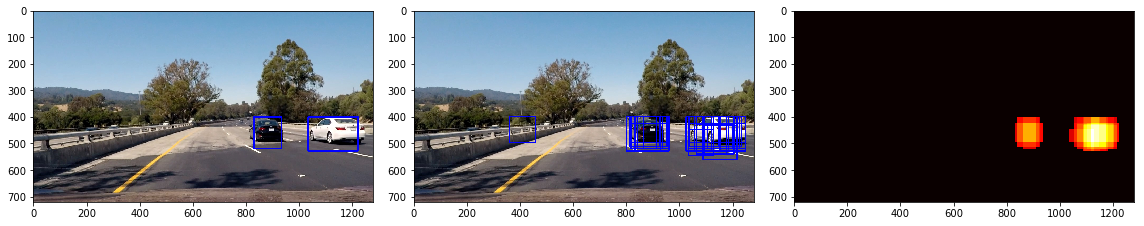

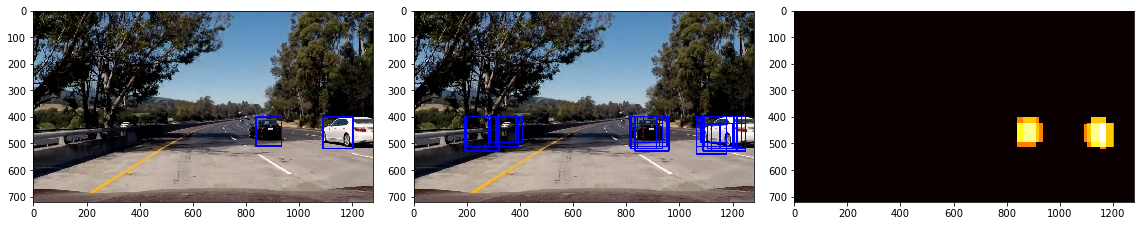

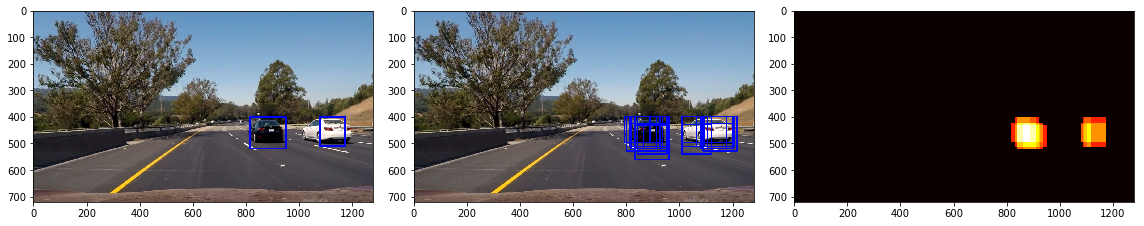

In [22]:
test_images = glob.glob('./test_images/test*.jpg')

threshold = 4

def finding_cars(init_image, final_output):
    bounding_boxes = []
    draw_img = np.copy(init_image)
    
    ystart = 400
    ystop = 656
    scale = 1.5
    draw_img, temp_boxes = find_cars(init_image, draw_img, ystart, ystop, scale, colorspace, clf, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bounding_boxes.append(temp_boxes)
    
    ystart = 400
    ystop = 656
    scale = 1.75
    draw_img, temp_boxes = find_cars(init_image, draw_img, ystart, ystop, scale, colorspace, clf, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bounding_boxes.append(temp_boxes)
    
    ystart = 400
    ystop = 656
    scale = 2.0
    draw_img, temp_boxes = find_cars(init_image, draw_img, ystart, ystop, scale, colorspace, clf, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bounding_boxes.append(temp_boxes)
    
    
    heatmap = np.zeros_like(init_image[:,:,0]).astype(np.float)
    bounding_boxes = [item for sublist in bounding_boxes for item in sublist] 
    
    heatmap = add_heat(heatmap, bounding_boxes)
        
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    out_img = draw_labeled_bboxes(np.copy(init_image), labels)
    
    if final_output:
        return out_img
    else:
        return out_img, draw_img, heatmap 

for index,img_path in enumerate(test_images):
    init_image = imread(img_path, mode='RGB')
    out_img, draw_img, heatmap = finding_cars(init_image, False)
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(out_img)
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    fig.tight_layout()
    plt.show()
    fig.savefig('./output_images/Combined_'+str(index)+'.jpg', bbox_inches='tight')

## Video

In [13]:
def process_image(image):
    out_img = finding_cars(image, True)
    return out_img

In [14]:
video_output = 'output_video/test_video.mp4'
clip1 = VideoFileClip("test_video/test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



MoviePy: building video file output_video/test_video.mp4
----------------------------------------

Writing video into output_video/test_video.mp4


  0%|                                                                                           | 0/37 [00:00<?, ?it/s]D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [03:36<00:00,  5.84s/it]


Done writing video in output_video/test_video.mp4 !
Your video is ready !
Wall time: 3min 37s


In [15]:
video_output = 'output_video/project_video.mp4'
clip1 = VideoFileClip("test_video/project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



MoviePy: building video file output_video/project_video.mp4
----------------------------------------

Writing video into output_video/project_video.mp4


  0%|                                                                                         | 0/1210 [00:00<?, ?it/s]D:\Installs\Conda\envs\tg\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|████████████████████████████████████████████████████████████████████████████| 1210/1210 [2:02:35<00:00,  5.83s/it]


Done writing video in output_video/project_video.mp4 !
Your video is ready !
Wall time: 2h 2min 36s
